In [1]:
import matplotlib as mpl
from scipy.io import netcdf
import matplotlib
#from numpy import *
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import datetime
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import xarray
import metpy.interpolate
import metpy.calc
import scipy.interpolate
#%matplotlib inline

In [2]:
# creates lists for each variable with file names of each 6 hour timestep for specified number of days

dstart = datetime(2018, 12, 10, 0, 0, 0)
ndays = 3 # 4 years including 1 leap year
nfiles = 4
fnameu = []
fnamev = []
fnamephi = []

for t in np.arange(0,ndays):
    
    for i in np.arange(0, nfiles):

        datefmt = '{:%Y%m%dT%H%M}'.format(dstart)
        dateyear = '{:%Y}'.format(dstart)
        dateday = '{:%m}'.format(dstart)
    
        fnameu.append('/g/data/cj37/BARRA/BARRA_R/v1/forecast/prs/wnd_ucmp/'+dateyear+'/'+dateday+'/wnd_ucmp-fc-prs-PT1H-BARRA_R-v1-'+datefmt+'Z.sub.nc')
        fnamev.append('/g/data/cj37/BARRA/BARRA_R/v1/forecast/prs/wnd_vcmp/'+dateyear+'/'+dateday+'/wnd_vcmp-fc-prs-PT1H-BARRA_R-v1-'+datefmt+'Z.sub.nc')
        fnamephi.append('/g/data/cj37/BARRA/BARRA_R/v1/forecast/prs/geop_ht/'+dateyear+'/'+dateday+'/geop_ht-fc-prs-PT1H-BARRA_R-v1-'+datefmt+'Z.sub.nc')

        dstart =  dstart + timedelta(hours=6)
    
    dstart =  dstart + timedelta(hours=0)
    


Coordinate limits:  (14, 28) (12, 37) <br> Coonooer bridge gridpoints: (19, 22)

In [3]:

nt = ndays*24

jstart = 241+18
jend = 241 + 20
istart = 690+21
iend = 690+23
pstart = 32
pend = 37
plevels = pend-pstart

# Load files from BARRA
chunks = {'time': 1, 'level': -1}

#u and v winds
u = xarray.open_mfdataset(fnameu, chunks = chunks, engine = 'netcdf4').wnd_ucmp[:, pstart:pend,jstart:jend,istart:iend]
v = xarray.open_mfdataset(fnamev, chunks = chunks, engine = 'netcdf4').wnd_vcmp[:, pstart:pend,jstart:jend,istart:iend]

#geopotential height
height = xarray.open_mfdataset(fnamephi, chunks = chunks).geop_ht[:, pstart:pend,jstart:jend,istart:iend]

#topography
topog = xarray.open_dataset('Downloads/topog-an-slv-PT0H-BARRA_R-v1-20150207T0000Z.nc')
topog = topog.topog[jstart:jend,istart:iend]

In [4]:
test_h = height.compute()
test_u = u.compute()
test_v = v.compute()

In [5]:
height = xarray.DataArray(test_h, name = 'height')
u = xarray.DataArray(test_u, name = 'u')
v = xarray.DataArray(test_v, name = 'v')

height['latitude'] = u['latitude']
height['longitude'] = u['longitude']

data = xarray.merge([height,u,v], compat = "override")
# data.to_netcdf('/g/data/v46/lh2344/height_uvwind.nc')

In [6]:
height.longitude

<xarray.DataArray 'longitude' (longitude: 2)>
array([143.20999, 143.32   ], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 143.2 143.3
Attributes:
    axis:           X
    units:          degrees_east
    standard_name:  longitude
    long_name:      longitude

In [7]:
# data = xarray.open_dataset('/g/data/v46/lh2344/height_uvwind.nc')

In [8]:
u = data.u[...,0,0]
v = data.v[...,0,0]
height = data.height[...,0,0]
topog = topog[0,0]

dstart = datetime(2018, 12, 10, 0, 0, 0)
EST = timedelta(hours = 10)
t_EST = np.arange(dstart + EST, dstart + timedelta(hours=nt)+EST, timedelta(hours=1)).astype(datetime)
u['time'] = t_EST
v['time'] = t_EST
height['time'] = t_EST

In [9]:
topog['latitude'] = height['latitude']
topog['longitude'] = height['longitude']

In [10]:
agl = xarray.DataArray(np.empty(height.shape), dims = height.dims)
agl = height-topog

In [11]:
uwind100 = xarray.DataArray(np.empty(u.shape[0]), 
                            coords = {"time": u.coords['time']})
vwind100 = xarray.DataArray(np.empty(u.shape[0]), 
                            coords = {"time": u.coords['time']})

uwind500 = xarray.DataArray(np.empty(u.shape[0]), 
                            coords = {"time": u.coords['time']})
vwind500 = xarray.DataArray(np.empty(u.shape[0]), 
                            coords = {"time": u.coords['time']})

interp_level = 100 # height to interpolate to

for t in np.arange(0,height.shape[0]):
    u_interp = scipy.interpolate.interp1d(agl.data[t], u.data[t]) # linear interpolation function
    v_interp = scipy.interpolate.interp1d(agl.data[t], v.data[t])
    
    uwind100[t] = u_interp(interp_level)   
    vwind100[t] = v_interp(interp_level) 

In [12]:
from metpy.units import units
direction = metpy.calc.wind_direction(uwind100*units("m/s"), vwind100*units("m/s"))
speed = metpy.calc.wind_speed(uwind100*units("m/s"), vwind100*units("m/s"))

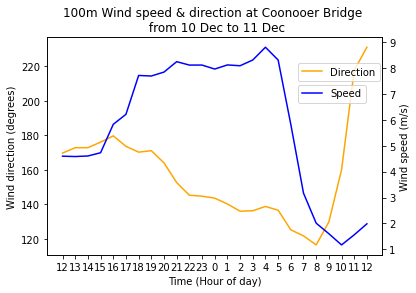

In [14]:
import matplotlib as mpl
import pandas as pd

start = datetime(2018,12,10,12,0,0)
end = datetime(2018,12,11,12,0,0)
time_slice = slice(start, end)
direction_xarray = xarray.DataArray(np.array(direction), name = "direction", coords = {"time":direction.time})
speed_xarray = xarray.DataArray(np.array(speed), name = "speed", coords = {"time":speed.time})

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(direction_xarray.time.sel(time = time_slice), direction_xarray.sel(time = time_slice), 
         color = 'orange', label = 'Direction')
ax1.set_ylabel('Wind direction (degrees)')
ax1.set_xlabel('Time (Hour of day)')
ax1.set_xticks(direction_xarray.time.sel(time = time_slice), pd.date_range(start,end, freq = 'H').hour)
ax1.legend(loc = [0.75,0.8])

ax2.plot(speed_xarray.time.sel(time = time_slice), speed_xarray.sel(time = time_slice), 
         color = 'blue', label = 'Speed')
ax2.set_ylabel('Wind speed (m/s)')
ax2.set_xlabel('Time (Hour of day)')
ax2.set_xticks(speed_xarray.time.sel(time = time_slice), pd.date_range(start,end, freq = 'H').hour)
ax2.set_title('100m Wind speed & direction at Coonooer Bridge \n from 10 Dec to 11 Dec')
ax2.legend(loc = [0.75,0.7])

plt.savefig('Case study speed and direction')

NameError: name 'direction1D' is not defined

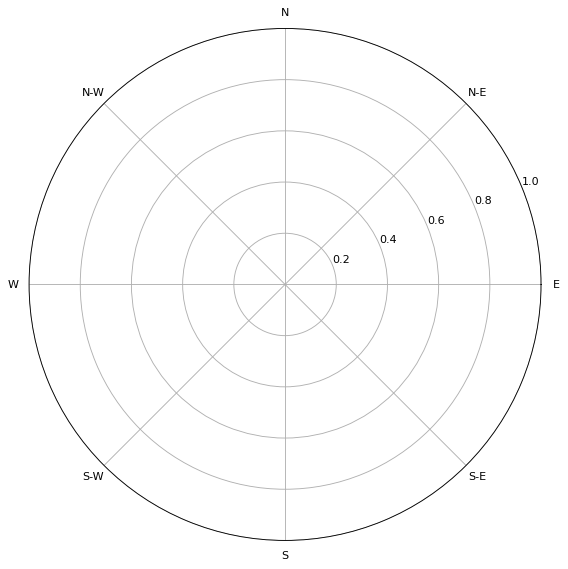

In [15]:
from windrose import WindroseAxes
new_labels = ["E", "N-E", "N", "N-W", "W", "S-W", "S", "S-E"]
ax = WindroseAxes.from_ax(theta_labels=new_labels)
ax.bar(direction1D, speed1D, normed=True, opening=0.8, edgecolor='white')
ax.set_legend()

In [ ]:
jetnight = xarray.open_dataset('/g/data/v46/lh2344/jetnightsv2')
jetnight2 = xarray.DataArray(jetnight.jetnight2_v2, dims = ['time','latitude','longitude'])[...,12:13,28:37]
jetnight2

In [ ]:
jetnight_true = jetnight2.sum(dim = ['latitude', 'longitude']) > 1
# On a jetnight an array is created so that every half hour timestep within a jetnight is defined at 'True' and
# 'False' otherwise
jethour_true = np.empty(jetnight2.shape[0]*24)
for day in range(0,jetnight2.shape[0]):
    daystart = day*24
    dayend = (day*24)+24
    for hour in range(daystart,dayend):
        jethour_true[hour] = jetnight_true[day]
jethour_true.sum()

jethour_true = np.array(jethour_true, dtype = bool)
jethour_false = ~jethour_true

In [ ]:
# filter for speed and direction when it is a jet night
speed_jetnight = np.array(speed[jethour_true,...]).reshape(-1,1).ravel()
direction_jetnight = np.array(direction[jethour_true,...]).reshape(-1,1).ravel()

# filter for speed and direction when it is not a jet night
speed_nonjetnight = np.array(speed[jethour_false,...]).reshape(-1,1).ravel()
direction_nonjetnight = np.array(direction[jethour_false,...]).reshape(-1,1).ravel()

In [ ]:
direction_jetnight.mean()

In [ ]:
new_labels = ["E", "N-E", "N", "N-W", "W", "S-W", "S", "S-E"]
ax = WindroseAxes.from_ax(theta_labels=new_labels)
ax.bar(direction_jetnight, speed_jetnight, normed=True, opening=0.8, edgecolor='white')
ax.set_legend(title = 'Wind speed (m/s)')
ax.set_title('Wind rose on jet nights (focused around -37\N{DEGREE SIGN}S, 144-145\N{DEGREE SIGN}E)')

In [ ]:
new_labels = ["E", "N-E", "N", "N-W", "W", "S-W", "S", "S-E"]
ax = WindroseAxes.from_ax(theta_labels=new_labels)
ax.bar(direction_nonjetnight, speed_nonjetnight, normed=True, opening=0.8, edgecolor='white')
ax.set_legend(title = 'Wind speed (m/s)')
ax.set_title('Wind rose on non jet nights (focused around -37\N{DEGREE SIGN}S, 144-145\N{DEGREE SIGN}E)')